### Libraries

In [2]:
!pip install -q transformers
!pip install -q wget

     |████████████████████████████████| 675kB 4.5MB/s 
     |████████████████████████████████| 1.1MB 19.1MB/s 
     |████████████████████████████████| 890kB 32.1MB/s 
     |████████████████████████████████| 3.8MB 43.3MB/s 


In [1]:
import torch
import wget
import os
import pandas as pd
import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
import string
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AdamW, AlbertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import matthews_corrcoef, roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Implementation of ALBERT fine-tuning for financial statement analysis

In [ ]:
def preprocess(sentences, labels, tokenizer, max_len=256):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        # sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return input_ids, attention_masks, labels

def prepare_dataset(input_ids, attention_masks, labels, train_faction=None, batch_size=8):
    # train_faction is none -> prepare a test dataset
    dataset = TensorDataset(input_ids, attention_masks, labels)
    if train_faction is not None:
        train_size = int(train_faction * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=batch_size
        )

        validation_dataloader = DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=batch_size
        )
        print('{} training samples, {} validation samples'.format(train_size, val_size))
        return train_dataloader, validation_dataloader
    else:
        test_dataloader = DataLoader(
            dataset, 
            sampler=SequentialSampler(dataset),
            batch_size=batch_size
        )
        print('{} test samples'.format(len(dataset)))
        return test_dataloader

def train(model, train_dataloader, validation_dataloader, epochs=5, lr=2e-5,
          eps=1e-8, num_warmup_steps=0, seed=42):
    optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=num_warmup_steps, 
                                                num_training_steps=total_steps)

    training_stats = []
    total_t0 = time.time()

    for epoch_i in range(epochs):
        print(f'At Epoch {epoch_i+1}/{epochs}')

        # Training
        print('Training...')
        train_predictions, train_true_labels = [], []

        t0 = time.time()
        
        total_train_accuracy = 0
        total_train_loss = 0

        model.train()

        for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # always clear any previously calculated gradients before backprop
            model.zero_grad()

            loss, logits = model(
                b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask,
                labels=b_labels
            )
            
            total_train_loss += loss.item()
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_train_accuracy += flat_accuracy(logits, label_ids)
            
            train_predictions.append(logits)
            train_true_labels.append(label_ids)

            # perform a backward pass to calcualte the gradients
            loss.backward()

            # clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # update parameters
            optimizer.step()

            # update learning rate
            scheduler.step()
        
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_total_mcc = mcc_total(train_predictions, train_true_labels)
        train_auc = auc_score(train_predictions, train_true_labels)
        training_time = format_time(time.time() - t0)

        print('Training Loss: {}, Training Accuracy: {}, Training MCC: {}, Training AUC: {}. Elapsed: {}'\
              .format(avg_train_loss, avg_train_accuracy, train_total_mcc, train_auc, training_time))

        # Validation
        print('Validation')
        val_predictions, val_true_labels = [], []

        t0 = time.time()

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0

        for batch in tqdm(validation_dataloader, total=len(validation_dataloader)):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # no need to construct compute graph as this is only needed for backprop
            with torch.no_grad():
                loss, logits = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels
                )
            
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)

            val_predictions.append(logits)
            val_true_labels.append(label_ids)

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        val_total_mcc = mcc_total(val_predictions, val_true_labels)
        val_auc = auc_score(val_predictions, val_true_labels)
        validation_time = format_time(time.time() - t0)

        print('Validation Loss: {}, Validation Accuracy: {}, Validation MCC: {}, Validation AUC: {}. Elapsed: {}'\
              .format(avg_val_loss, avg_val_accuracy, val_total_mcc, val_auc, validation_time))

        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Accuracy': avg_train_accuracy,
                'Training MCC': train_total_mcc,
                'Training AUC': train_auc,
                'Validation Loss': avg_val_loss,
                'Validation Accuracy': avg_val_accuracy,
                'Validation MCC': val_total_mcc,
                'Validation AUC': val_auc,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print('Traninig complete! Elapsed: {}'.format(format_time(time.time() - total_t0)))
    return training_stats

def evaluate(model, test_dataloader):
    print('Predicting labels on test set...')

    model.eval()

    total_test_accuracy = 0
    total_test_loss = 0
    predictions, true_labels = [], []

    t0 = time.time()

    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            loss, logits = model(b_input_ids, token_type_ids=None, 
                                attention_mask=b_input_mask, labels=b_labels)
        
        total_test_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_test_accuracy += flat_accuracy(logits, label_ids)

        predictions.append(logits)
        true_labels.append(label_ids)
        avg_test_accurary = total_test_accuracy / len(test_dataloader)
        avg_test_loss = total_test_loss / len(test_dataloader)

    total_mcc = mcc_total(predictions, true_labels)
    auc = auc_score(predictions, true_labels)
    print('Done. Test Average Loss: {}, Test Average Accuracy: {}, Test MCC Score: {}, Test AUC: {}. Elapsed: {}'.format(
        avg_test_loss, avg_test_accurary, total_mcc, auc, format_time(time.time() - t0)))
    return avg_test_loss, avg_test_accurary, total_mcc, auc
    # mcc_set = mcc_per_batch(predictions, true_labels)
    # return mcc_set, total_mcc

def run(model_name, train_df, test_df, epochs=5, lr=2e-5, batch_size=16, max_len=256):
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        # num_labels=2,
        # output_attentions=False,
        # output_hidden_states=False,
    )
    model.cuda()
    # model.to(device)
    
    train_sentences, train_labels = train_df.sentence.values, train_df.label.values
    train_input_ids, train_attention_masks, train_labels = \
        preprocess(train_sentences, train_labels, tokenizer, max_len=max_len)
    train_dataloader, validation_dataloader = prepare_dataset(
        train_input_ids, train_attention_masks, train_labels, train_faction=7/9,
        batch_size=batch_size
    )
    training_stats = train(model, train_dataloader, validation_dataloader, 
                           epochs=epochs, lr=lr)

    test_sentences, test_labels = test_df.sentence.values, test_df.label.values
    test_input_ids, test_attention_masks, test_labels = \
        preprocess(test_sentences, test_labels, tokenizer, max_len=max_len)
    test_dataloader = prepare_dataset(
        test_input_ids, test_attention_masks, test_labels, batch_size=batch_size)
    # we only report the results before retraining with validation set
    print('-------------------------------------')
    print('Before retraining with validation set')
    _, __, ___, ____ = evaluate(model, test_dataloader)
    training_stats2 = train(model, validation_dataloader, test_dataloader, 
                            epochs=2, lr=lr)
    print('------------------------------------')
    print('After retraining with validation set')
    avg_test_loss, avg_test_accurary, total_mcc, auc = evaluate(model, test_dataloader)

    return training_stats, training_stats2, model
    

def plot_training_stats(training_stats):
    df_stats = pd.DataFrame(training_stats)
    df_stats = df_stats.set_index('epoch')
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3])

    plt.show()

# helper function
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def mcc_per_batch(predictions, true_labels):
    matthews_set = []
    print('Calculating MCC score for each batch...')

    # For each input batch...
    for i in range(len(true_labels)):
    
        # The predictions for this batch are a 2-column ndarray (one column for "0" 
        # and one column for "1"). Pick the label with the highest value and turn this
        # in to a list of 0s and 1s.
        pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
        
        # Calculate and store the coef for this batch.  
        matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
        matthews_set.append(matthews)

    return matthews_set

def mcc_total(predictions, true_labels):
    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Calculate the MCC
    mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

    return mcc

def plot_mcc_per_batch(matthews_set):
    ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

    plt.title('MCC Score per Batch')
    plt.ylabel('MCC Score (-1 to +1)')
    plt.xlabel('Batch #')

    plt.show()

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))   

def auc_score(predictions, true_labels):
    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = np.concatenate(true_labels, axis=0)

    return roc_auc_score(flat_true_labels, flat_predictions, average='weighted') 

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU: {}'.format(torch.cuda.device_count()))

GPU: 1


In [ ]:
df = pd.read_pickle('/content/drive/My Drive/CS263/final_lean_sample.pkl')
df.columns = ['label', 'sentence']

We select maximun length = 512 in tokenizer because it is larger than most of the sizes of texts and it does not cost too much GPU memory

count    7068.000000
mean      237.183503
std        67.430666
min        76.000000
25%       196.000000
50%       227.000000
75%       265.000000
max       811.000000
Name: sentence, dtype: float64


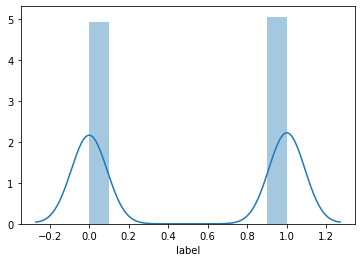

In [5]:
def text_len(text):
    return len(text.split())
print(df.sentence.apply(text_len).describe())
sns.distplot(df['label'])

### Model selection

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
training_data = {}
model_names = ['albert-base-v1', 'albert-base-v2', 'albert-large-v1', 
               'albert-large-v2', 'albert-xlarge-v1', 'albert-xlarge-v2',
               'albert-xxlarge-v1', 'albert-xxlarge-v2']
for model_name in model_names:
    print(model_name)
    kf = KFold(n_splits=10)
    stats1_arr, stat2_arr = [], []
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index, :], df.iloc[test_index, :]
        stats1, stats2, model = run(model_name, train_df, test_df, max_len=512, batch_size=8)
        stats1_arr.append(stats1)
        stats2_arr.append(stats2)
    training_stats1 = np.mean(stats1_arr)
    training_stats2 = np.mean(stats2_arr)
    training_data[model_name] = {'training_stats1': training_stats1,
                                 'training_stats2': training_stats2,
                                 'model': model}

In [ ]:
training_results = {}
for model_name in training_data:
    training_results[model_name] = {'training_stats1': training_data[model_name]['training_stats1'],
                                    'training_stats2': training_data[model_name]['training_stats2']}

In [ ]:
import pickle
pickle.dump(training_results, open('/content/drive/My Drive/CS263/model_selection.training.results.batch8.seq512.pkl', 'wb'))

In [ ]:
pickle.load(open('/content/drive/My Drive/CS263/model_selection.training.results.pkl', 'rb'))

### Hyperparameter grid search

In [ ]:
lr_set = [2e-6, 2e-5, 2e-4]
batch_size_set = [1, 2, 4, 8, 16, 32, 64, 128, 256]
max_len_set = [816, 512, 256, 128, 64]

We select 'albert-base-v2' based on the model selection results

#### search for learning rate

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
training_data = {}
model_name = 'albert-base-v2'
print(model_name)

# select learning rate
for lr in lr_set:
    kf = KFold(n_splits=10)
    stats1_arr, stat2_arr = [], []
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index, :], df.iloc[test_index, :]
        stats1, stats2, model = run(model_name, train_df, test_df, lr=lr, epochs=10, batch_size=8, max_len=512)
        stats1_arr.append(stats1)
        stats2_arr.append(stats2)
    training_stats1 = np.mean(stats1_arr)
    training_stats2 = np.mean(stats2_arr)
    training_data[lr] = {'training_stats1': training_stats1,
                         'training_stats2': training_stats2,
                         'model': model}

In [ ]:
training_results = {}
for model_name in training_data:
    training_results[model_name] = {'training_stats1': training_data[model_name]['training_stats1'],
                                    'training_stats2': training_data[model_name]['training_stats2']}
import pickle
pickle.dump(training_results, open('/content/drive/My Drive/CS263/lr_selection.training.results.batch8.seq512.epoch10.pkl', 'wb'))
pickle.load(open('/content/drive/My Drive/CS263/lr_selection.training.results.batch8.seq512.epoch10.pkl', 'rb'))

#### search for batch size

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
training_data = {}
model_name = 'albert-base-v2'
print(model_name)

# select learning rate
for batch_size in batch_size_set:
    kf = KFold(n_splits=10)
    stats1_arr, stat2_arr = [], []
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index, :], df.iloc[test_index, :]
        stats1, stats2, model = run(model_name, train_df, test_df, lr=2e-06, epochs=5, batch_size=batch_size, max_len=512)
        stats1_arr.append(stats1)
        stats2_arr.append(stats2)
    training_stats1 = np.mean(stats1_arr)
    training_stats2 = np.mean(stats2_arr)
    training_data[batch_size] = {'training_stats1': training_stats1,
                                 'training_stats2': training_stats2,
                                 'model': model}

In [ ]:
training_results = {}
for model_name in training_data:
    training_results[model_name] = {'training_stats1': training_data[model_name]['training_stats1'],
                                    'training_stats2': training_data[model_name]['training_stats2']}
import pickle
pickle.dump(training_results, open('/content/drive/My Drive/CS263/batch_selection.training.results.seq512.epoch5.lr2e6.pkl', 'wb'))

In [ ]:
training_results = {}
for model_name in training_data:
    training_results[model_name] = {'training_stats1': training_data[model_name]['training_stats1'],
                                    'training_stats2': training_data[model_name]['training_stats2']}
import pickle
pickle.dump(training_results, open('/content/drive/My Drive/CS263/seq_selection.training.results.batch2.epoch5.lr2e6.pkl', 'wb'))

#### search for max sequence length

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
training_data = {}
model_name = 'albert-base-v2'
print(model_name)

# select learning rate
for max_len in max_len_set:
    kf = KFold(n_splits=10)
    stats1_arr, stat2_arr = [], []
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index, :], df.iloc[test_index, :]
        stats1, stats2, model = run(model_name, train_df, test_df, lr=2e-06, epochs=5, batch_size=4, max_len=max_len)
        stats1_arr.append(stats1)
        stats2_arr.append(stats2)
    training_stats1 = np.mean(stats1_arr)
    training_stats2 = np.mean(stats2_arr)
    training_data[max_len] = {'training_stats1': training_stats1,
                              'training_stats2': training_stats2,
                              'model': model}

### ALBERT vs BERT

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
training_data = {}
model_names = ['bert-base-uncased']
for model_name in model_names:
    print(model_name)
    kf = KFold(n_splits=10)
    stats1_arr, stat2_arr = [], []
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index, :], df.iloc[test_index, :]
        stats1, stats2, model = run(model_name, train_df, test_df, max_len=512, batch_size=16, lr=2e-5, epochs=5)
        stats1_arr.append(stats1)
        stats2_arr.append(stats2)
    training_stats1 = np.mean(stats1_arr)
    training_stats2 = np.mean(stats2_arr)
    training_data[model_name] = {'training_stats1': training_stats1,
                                 'training_stats2': training_stats2,
                                 'model': model}

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
training_data = {}
model_names = ['albert-base-v2']
for model_name in model_names:
    print(model_name)
    kf = KFold(n_splits=10)
    stats1_arr, stat2_arr = [], []
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index, :], df.iloc[test_index, :]
        stats1, stats2, model = run(model_name, train_df, test_df, max_len=512, batch_size=16, lr=2e-6, epochs=5)
        stats1_arr.append(stats1)
        stats2_arr.append(stats2)
    training_stats1 = np.mean(stats1_arr)
    training_stats2 = np.mean(stats2_arr)
    training_data[model_name] = {'training_stats1': training_stats1,
                                 'training_stats2': training_stats2,
                                 'model': model}

### Preliminary Results

In [ ]:
import pandas as pd
import pickle
# results = pickle.load(open('/content/drive/My Drive/CS263/lr_selection.training.results.batch8.seq512.epoch10.pkl', 'rb'))
results = pickle.load(open('/content/drive/My Drive/CS263/lr_selection.training.results.batch8.seq512.epoch10.pkl', 'rb'))
pd.DataFrame(results[2e-5]['training_stats2'])

,epoch,Training Loss,Training Accuracy,Training MCC,Training AUC,Validation Loss,Validation Accuracy,Validation MCC,Validation AUC,Training Time,Validation Time
0,1,0.675172,0.589454,0.177338,0.587994,0.610353,0.669476,0.356257,0.674167,0:01:21,0:00:14
1,2,0.649728,0.624058,0.253768,0.625274,0.610857,0.686330,0.380989,0.689827,0:01:21,0:00:14


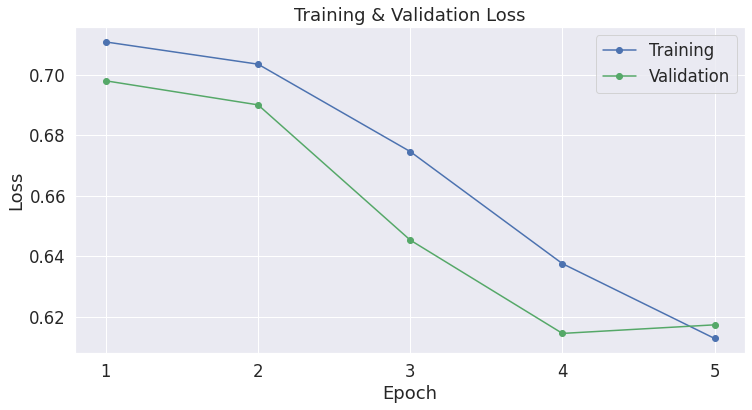

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_stats(training_stats):
    df_stats = pd.DataFrame(training_stats)
    df_stats = df_stats.set_index('epoch')
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4, 5])

    plt.show()

plot_training_stats(pd.DataFrame(results['albert-base-v2']['training_stats1']))

### GPU memory profiling

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.7 GB  |     Proc size: 3.5 GB
GPU RAM Free: 9901MB | Used: 6379MB | Util  39% | Total     16280MB


Reference:
1. https://mccormickml.com/2019/07/22/BERT-fine-tuning 
2. https://github.com/huggingface/transformers/blob/master/examples/run_glue.py
3. https://arxiv.org/abs/1909.11942
4. https://github.com/google-research/ALBERT